# Estimate p-Thyrosim parameters

+ **1/5/2020**: Just as an experiment, try increasing T3's likelihood by 10 times to see if it improves fit. 

+ **1/2/2020**: Blakesley fit still looks bad. Try adding a penalty term $\lambda(y_i - \hat{y}_i)$ to the 9, 13, 24, 28th TSH time points. Initially we set $\lambda = 100$.

+ **12/26/2020** Drop FT4 data in jonklaas patient in fit since, after converting to TT4, the ranges doon't match. Also we dont fit A0, B0 as the resulting blakesley TSH fit would have too little amplitude. For now, fit only hill function parameters + T4 -> T3 conversion. 

How I tried FFT -> TT4 conversion. First we convert ng/dL (jonklaas unit) to $\mu$mol (thyrosim unit for FT4). 

$$\frac{1 ng}{dL}\frac{10dL}{L}\frac{10^{-9}g}{1ng}\frac{1 mol}{777g}\frac{10^6\mu mol}{1 mol} V_b = \frac{V_b}{100\times 777}\mu mol$$

Thus $x$ (ng/dL) FFT is equivalent to $\frac{x V_b}{100\times 777} \mu$mol of FT4. We convert FT4 to TT4 by solving for TT4 in 

$$FT4 (\mu mol) = (A + B(TT4) + C(TT4)^2 + D(TT4)^3)TT4$$

via `Roots.jl` package. 

+ **12/6/2020** For updated Jonklaas patients, we group them into 4 different groups so that there are only 8 T4/T3 secretion rates to fit. Also fixed some bug in fitting code. 

+ **11/3/2020** Previous schneider fit looks good. We got more data from Jonklaas so we will try including them into the fitting process. First we try to see if we can adjust T4/T3 secretion rates so that the starting T4/T3/TSH matches what is observed

+ **10/6/2020** Got updated data from Schneider, which contains 6 week TSH values. After matching with original Schneider data, we got about 100 patients that we can confidently match with the old dataset. We will use these patients in the fitting process instead. Note we use the initial dose for all patients because his 2019 paper says doses are only adjusted in 6-8 week intervals.

+ **9/21/2020** Try different dose prediction algorithm. We find a dose that minimizes the following:
$$\frac{|T4 - 75|}{60} + \frac{|TSH - 2.5|}{4}$$
where 75 and 2.5 are midpoints of T4 and TSH, and 60 and 4 are the length of the normal range of T4 and TSH. Thus, error are normalized between compartments.

+ **9/18/2020** Also fit female reference volume. In current model, the predicted doses are too high for normal and overweight females, but too low for overweight and obese males.

+ **9/8/2020** Fit exact TSH values for schneider patients. Use starting TSH values (**TSH.preop**) as response, and only include patients whose initial and euthyroid dose is the same. This assumes patients who were getting the correct dose maintains a similar TSH level.

+ **8/27/2020** Met with distefano. He suggested stop fitting Km values and to put bounds on the parameter space. 

+ ** 8/19/2020** Schneider loglikelihood got worse after 24h fitting because blakesley dominated the error. This time, try starting with model fitted to blakesley data and only fit schneider error. Also add logl tracker for different BMI/sex categories to monitor them separately. 

+ ** 8/10/2020** Separate Schneider fit by sex and BMI category. Estimate mean and variance from each category separately. 

+ ** 8/10/2020** Fitting works but bias due to sex still remains. Try fitting female reference Vp volume. 

+ ** 7/23/2020** Fix bug in loglikelihood calculation. First we fit blakesley data only to obtain reasonable fit, then use that as starting point to fit all 3 datasets on the cluster.

+ ** 7/18/2020** Mauricio compiled a list of parameters by searching through Thyrosim paper's history. We will re-fit all parameters that were fitted before.

+ **6/21/2020** Now we try maximum likelihood approach because it is easier to justify compared to our previous approach. We assume data from each compartment T4/T3/TSH are independent gaussian with some variance $\sigma_{T4}, \sigma_{T3}, \sigma_{TSH}$. Then we treat the ODE solution as the mean of the response ($\mu$). The negative loglikelihood for each compartment is
$$\frac{n\log(2\pi)}{2} + n\log(\sigma) + \sum\frac{(y - \mu)^2}{2\sigma^2}.$$
We minimize this function summed over T4/T3/TSH compartments. For Schneider's data, we use mean dosage predicted as the mean of the response, where the $y$s are the euthyroid dose. Also, for Blakesley patients, the initial condition for every compartment is now set to steady state by letting the model run for 30 days prior to fitting. 


+ **5/17/2020**: What I tried on 5/13 doesn't work. If Blakesley T3 and Jonklaas gets fitted, schneider prediction will look bad (see `test` branch on Github). Thus now I try to fit every rate in the thyroid hormone distribution and elimination submodel (Fig 3 of Eisenburg 2008) along with the 6 parameters we introduced for the hill functions. Also, we only fit on schneider toy data since our previous best fit was obtained from a toy data fit. 


+ **5/13/2020**: Things I tried for past 2 weeks didn't really work. Now I will start with the best model we have (obtained on 4/28) and try to fix the problems with it. Namely, the T3 values in Blakesley are too low. We fix this issue by fitting S3, k05, k3dissolve and k3excrete. We do not fit k3absorb because it is a parameter adjustable on Thyrosim website (default 0.88).


+ **4/30/2020 notes**: Blakesley T3 fit keep screwing up. Thus we start fitting T3 secretion and excretion rate. This is achieved by making `dial` part of the `p` parameter. 


+ **4/21/2020 notes**: In `problem_diagnostics.ipynb` and `schneider_avg_predicted_dose.svg`, predicted dose for skinnier patients are overestimated. Plotting a few normal patients reveal that while ~2.3ug/kg T4 is sufficient, ~1.8ug give rise to large (~4.5) TSH values. Perhaps scaling the error function by 0.22 introduced in 3/29 is causing this screw as smaller dose is forced to approach TSH 4.5. Back then, we were fitting k21 and k31 which we shouldn't be. Therefore we try getting rid of the scaling. Also, we try **include Blakesley's T3 data in fitting**.


+ **4/14/2020 notes**: Realized we shouldn't be fitting k21 and k31. Instead, fit k02 and k05 because they are the terms that handle T4/T3 eliminations. Also, use absolute error in objective instead of scaled error, because otherwise one of the hill coefficients will want to blowup to infinity. 

    Furthremore, Mauricio's python notebook for Schneider's data shows that:
    + We are underpredicting doses for males and overpredicting for females. **This suggests a problem with our model's sex parametrization that is somewhat deeper than fitting**
    

+ **3/29/2020 notes**: According to `problem_diagnostics.ipynb`, the current fit improves error by making every dose achieve euthyroidism. This leads to severely underpredicted T4 dose: median predicted euthyroid dose is ~0.5ug/kg while in real data it should be ~1.6. The reason might be because we have no schneider patients that's is supposed to have a *"high TSH level"*. To solve this problem, we will assign an error of 
$$\log(4.5 / TSH) / 0.22$$
for patients whose predicted TSH is within normal range but whose initial dose is smaller than their euthyroid dose (i.e. we know the initial dose is insufficient). Division by 0.22 is because only 91 / 400 patients satisfy this criteria, so we scale up their error proportion.

In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Plots
using Optim
using Statistics
using LinearAlgebra

In [2]:
BLAS.set_num_threads(1)
Threads.nthreads()

1

## Import data and initial conditions

In [3]:
#schneider data
alldata, train_data = schneider_data()

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
# patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
# jonklaas_tspan = (0.0, 8.0)

# updated Jonklaas data
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

([61.8 62.8 1.72 1.0; 64.1 67.1 1.6 0.0; … ; 78.1 77.2 1.79 1.0; 89.7 89.7 1.78 0.0], [100.0 112.0; 112.0 125.0; … ; 137.0 137.0; 137.0 137.0], [1.19 1.24 1.45 1.31; 1.14 0.98 1.64 1.61; … ; 1.06 0.95 1.2 1.11; 1.0 1.1 1.3 1.4], [1.71 1.71 1.44 1.14; 1.08 1.19 1.48 1.39; … ; 0.96 1.02 0.86 1.07; 1.0 1.09 1.01 1.1], [0.63 0.7 0.37 0.9; 1.4 1.6 0.82 0.45; … ; 1.6 1.25 2.9 3.6; 0.84 0.85 0.8 0.7])

In [4]:
function objective(
    p_being_optimized::Vector, # first n elem is parameters, n+1:end is T4/T3 secrete rates
    fitting_index::Vector, 
    lowerbound::Vector,
    upperbound::Vector,
    blakesley_time::Matrix,
    blakesley_my400_data::Matrix, 
    blakesley_my450_data::Matrix, 
    blakesley_my600_data::Matrix,
    jonklaas_time::Vector, 
    jonklaas_patient_t4::Matrix, 
    jonklaas_patient_t3::Matrix, 
    jonklaas_patient_tsh::Matrix, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    jonklaas_exclude_idx::Vector,
    jonklaas_secrete_rate_clusters::Vector,
    schneider_height::Vector, 
    schneider_weight::Vector, 
    schneider_sex::Vector, 
    schneider_tspan::Vector, 
    schneider_init_tsh::Vector, 
    schneider_euthy_dose::Vector, 
    schneider_init_dose::Vector,
    schneider_postTSH::Vector;      
    verbose::Bool = false, #set to true to display intermediate errors,
    blakesley_tsh_penalty::Float64 = 0.0,
    )
    total_neg_logl = 0.0
    # quick return
    for (i, val) in enumerate(p_being_optimized)
        if !(lowerbound[i] <= val <= upperbound[i])
            return Inf
        end
    end
    #
    # Blakesley male, 22.5 BMI (1.77m, 70 kg)
    #
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= @view(p_being_optimized[1:length(fitting_index)])
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
    p_400 = p_450 = p_600 = copy(p)
    find_patient_ic!(ic, p_400, 30)
    # solve different ODE problems for varying doses
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 4, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 4, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 4, 7])
    T4_error = blakesley_t4_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[47], p[61]) + 
               blakesley_t4_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[47], p[61]) + 
               blakesley_t4_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[47], p[61])
    T3_error = blakesley_t3_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[47], p[62]) + 
               blakesley_t3_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[47], p[62]) + 
               blakesley_t3_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[47], p[62])
    TSH_error = blakesley_tsh_neg_logl(sol_400,blakesley_time,blakesley_my400_data,p[48],p[63],blakesley_tsh_penalty) + 
                blakesley_tsh_neg_logl(sol_450,blakesley_time,blakesley_my450_data,p[48],p[63],blakesley_tsh_penalty) + 
                blakesley_tsh_neg_logl(sol_600,blakesley_time,blakesley_my600_data,p[48],p[63],blakesley_tsh_penalty)
    blakesley_male_err = T4_error + T3_error + TSH_error
    verbose && println("blakesley male neg logl: T4 = $T4_error, T3 = $T3_error, TSH = $TSH_error")
    total_neg_logl += blakesley_male_err
    #
    # Blakesley female, 22.5 BMI (1.61m, 58kg)
    #
    ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, 1.61, 58, false) 
    p[fitting_index] .= @view(p_being_optimized[1:length(fitting_index)])
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
    p_400 = p_450 = p_600 = copy(p)
    find_patient_ic!(ic, p_400, 30)
    # solve different ODE problems for varying doses
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 4, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 4, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 4, 7])
    T4_error = blakesley_t4_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[47], p[61]) + 
               blakesley_t4_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[47], p[61]) + 
               blakesley_t4_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[47], p[61])
    T3_error = blakesley_t3_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[47], p[62]) + 
               blakesley_t3_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[47], p[62]) + 
               blakesley_t3_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[47], p[62])
    TSH_error = blakesley_tsh_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[48], p[63],blakesley_tsh_penalty) + 
                blakesley_tsh_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[48], p[63],blakesley_tsh_penalty) + 
                blakesley_tsh_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[48], p[63],blakesley_tsh_penalty)
    blakesley_err = T4_error + T3_error + TSH_error
    verbose && println("blakesley female neg logl: T4 = $T4_error, T3 = $T3_error, TSH = $TSH_error")
    total_neg_logl += blakesley_err
    #
    # Old Jonklaas data
    #
#     tspan = (0.0, 8.0)
#     cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
#     jonklaas_err = 0.0
#     for i in 1:size(jonklaas_patient_dose, 1)
#         # initialize ODE problem for patient 1
#         height, weight, sex = jonklaas_patient_param[i, :]
#         T4init, T3init, TSHinit = jonklaas_patient_t4[i, 1], jonklaas_patient_t3[i, 1], jonklaas_patient_tsh[i, 1]
#         ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
#         set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
#         # set parameters being fitted
#         p[fitting_index] .= @view(p_being_optimized[1:length(fitting_index)])
#         # solve different ODE problems for varying doses
#         p[56] = jonklaas_patient_dose[i] / 651.0
#         prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
#         sol  = solve(prob, save_idxs=4)
#         jonklaas_err += jonklaas_t3_neg_logl(sol, jonklaas_time, 
#             jonklaas_patient_t3[i, :], p[47], p[62])
#     end
#     verbose && println("jonklaas's negative loglikelihood = $jonklaas_err")
#     total_neg_logl += jonklaas_err
    #
    # Updated Jonklaas data
    #
    jonklaas_err = T4_error = T3_error = TSH_error = 0.0
    dial = [1.0; 0.88; 1.0; 0.88]
    nparams = length(fitting_index)
    nsamples = size(jonklaas_patient_param, 1)
    cbk = PeriodicCallback(add_dose!, 24.0) 
    weight_w1 = jonklaas_patient_param[:, 1] # week 1 weight
    height = jonklaas_patient_param[:, 3]
    sex = convert(BitVector, jonklaas_patient_param[:, 4])
    for i in 1:nsamples
        # run model to steady state before actual simulation
#         cluster = jonklaas_secrete_rate_clusters[i]
#         dial[1] = p_being_optimized[nparams + 2cluster - 1]
#         dial[3] = p_being_optimized[nparams + 2cluster]
        dial[1] = dial[3] = 1.0
        sol = simulate(height[i], weight_w1[i], sex[i], days=50, dial=dial, warmup=false, 
            fitting_index=fitting_index, parameters=p_being_optimized[1:length(fitting_index)])
        _, p = initialize(dial, true, height[i], weight_w1[i], sex[i])
        p[fitting_index] .= @view(p_being_optimized[1:length(fitting_index)])
#         T4_error += jonklaas_T4_neg_logl(sol, jonklaas_patient_t4[i, 2], p[47], p[61])
        T3_error += jonklaas_T3_neg_logl(sol, jonklaas_patient_t3[i, 2], p[47], p[62])
        TSH_error += jonklaas_TSH_neg_logl(sol, jonklaas_patient_tsh[i, 2], p[47], p[63])
        # run first 8 week simulations, interpolate weight weekly
        weight_diff = (jonklaas_patient_param[i, 2] - jonklaas_patient_param[i, 1]) / 16.0
        dial[1] = dial[3] = 0.0
        for week in 1:8
            # reset parameters using new weight
            ic, p = initialize(dial, true, height[i], weight_w1[i] + week*weight_diff, sex[i])
            p[55] = jonklaas_patient_dose[i, 1] / 777.0
            p[fitting_index] .= @view(p_being_optimized[1:length(fitting_index)])
            # use last week's end value
            ic .= sol[end]
            ic[10] += p[55] # manually add dose for first day of the week
            prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
            sol  = solve(prob)
        end
#         T4_error += jonklaas_T4_neg_logl(sol, jonklaas_patient_t4[i, 3], p[47], p[61])
        T3_error += jonklaas_T3_neg_logl(sol, jonklaas_patient_t3[i, 3], p[47], p[62])
        TSH_error += jonklaas_TSH_neg_logl(sol, jonklaas_patient_tsh[i, 3], p[47], p[63])
        # run next 8 week, interpolate weight weekly
        for week in 9:16
            # reset parameters using new weight
            ic, p = initialize(dial, true, height[i], weight_w1[i] + week*weight_diff, sex[i])
            p[55] = jonklaas_patient_dose[i, 2] / 777.0
            p[fitting_index] .= @view(p_being_optimized[1:length(fitting_index)])
            # use last week's end value
            ic .= sol[end]
            ic[10] += p[55] # manually add dose for first day of the week
            prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
            sol  = solve(prob)
        end
#         T4_error += jonklaas_T4_neg_logl(sol, jonklaas_patient_t4[i, 3], p[47], p[61])
        T3_error += jonklaas_T3_neg_logl(sol, jonklaas_patient_t3[i, 3], p[47], p[62])
        TSH_error += jonklaas_TSH_neg_logl(sol, jonklaas_patient_tsh[i, 3], p[47], p[63])
    end
    verbose && println("jonklaas neg logl: T4 = $T4_error, T3 = $T3_error, TSH = $TSH_error")
    jonklaas_err = T3_error + TSH_error
    total_neg_logl += jonklaas_err
    # 
    # Schneider
    #
#     num_params = length(fitting_index)
#     num_sample = length(schneider_height)
#     num_params == length(fitting_index) || error("check parameter length bro")
#     schneider_logl = zeros(Threads.nthreads())
#     Threads.@threads for i in 1:num_sample
#         # get current patient's parameters
#         sex = schneider_sex[i]
#         h = schneider_height[i]
#         w = schneider_weight[i]
#         euthyroid_dose = schneider_euthy_dose[i]
#         initial_dose = schneider_init_dose[i]
#         initial_tsh = schneider_init_tsh[i]
#         id = Threads.threadid()
#         # calculate observations neg logl (units in mcg/kg)
#         μ = schneider_postTSH[i] # post operative TSH values after 6 weeks treatment
#         σ = p[64]
#         y = schneider_end_tsh(p_being_optimized, fitting_index, h, w, sex, 
#             initial_tsh, initial_dose)
#         schneider_logl[id] += log(2π) / 2 + log(σ) + (y - μ)^2 / 2 / σ^2
#     end
#     verbose && println("schneider's negative loglikelihood = $(sum(schneider_logl))")
#     total_neg_logl += sum(schneider_logl)
    #
    # Return final error
    #
    return total_neg_logl
end

objective (generic function with 1 method)

### Helper functions for calculating error

In [5]:
# gives 400/450/600 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end
# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
# gives T4 dose at hour 24
function new_jonklaas_condition(u, t, integrator)
    return t - 24.0
end
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
function blakesley_t4_neg_logl(sol, time, data, Vp, σ) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_t3_neg_logl(sol, time, data, Vp, σ) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i])[2] * 651.0 / Vp
            tot_loss += (T3_predicted - data[i, 2])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_tsh_neg_logl(sol, time, data, Vtsh, σ, λ = 0.0) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
        # add penalty for 1st and 2nd high/low peak in TSH data (no penalty if λ=0)           
        for i in [9, 13, 24, 28]
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += λ * (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
# μmol (thyrosim unit for FT4) = Vb/100/777 ng/dL (jonklaas unit)
function FT4_to_TT4(FT4, Vb)
    # FT4 in ng/dL. Need to convert it to μmol
    f(TT4) = (0.000289 + 0.000214TT4 + 0.000128*TT4^2 + -8.83*10^-6*TT4^3) * TT4 - FT4 * Vb / 77700
    return fzero(f, 100)
end
# calculate new jonklaas error for T4 at end of sol
function jonklaas_T4_neg_logl(sol, data, Vp, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][1] * 777.0 / Vp
        tot_loss += (predicted - FT4_to_TT4(data))^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
# calculate new jonklaas error for T3 at end of sol
function jonklaas_T3_neg_logl(sol, data, Vp, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][4] * 651.0 / Vp
        tot_loss += (predicted - data)^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
# calculate new jonklaas error for TSH at end of sol
function jonklaas_TSH_neg_logl(sol, data, Vtsh, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][7] * 5.6 / Vtsh
        tot_loss += (predicted - data)^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
function schneider_end_tsh( 
    current_iter::Vector,
    fitting_index::Vector,
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    initial_tsh::Float64,
    initial_dose::Float64
    )

    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= @view(current_iter[1:length(fitting_index)])

    # run ODE simulation
    p[55] = initial_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk) # simulate for 6 weeks
    sol   = solve(prob, save_idxs=[1, 7])

    # return observed value
    return sol.u[end][2] * 5.6 / p[48]
end
function schneider_TSH_err(initTSH, sol, Vtsh)
    tsh = sol.u[end][2] * 5.6 / Vtsh
    return true
end
function TSH_within_interval(sol, Vtsh)
    tot_loss = 0
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end
# Calculate mean/std of eythyroid dose (mcg/kg) for 
# male and female patients in different BMI categories 
function compute_patient_categories(
    sex::AbstractVector, 
    bmi::AbstractVector,
    euthyroid_dose::AbstractVector
    )
    categories = Dict{Symbol, Tuple{Float64, Float64}}()
    
    # get index for different cateories
    male_normal_idx = intersect(findall(iszero, sex), findall(x -> x < 24.9, bmi))
    male_overweight_idx = intersect(findall(iszero, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    male_obese_idx = intersect(findall(iszero, sex), findall(x -> 29.9 <= x, bmi))
    female_normal_idx = intersect(findall(isone, sex), findall(x -> x < 24.9, bmi))
    female_overweight_idx = intersect(findall(isone, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    female_obese_idx = intersect(findall(isone, sex), findall(x -> 29.9 <= x, bmi))
    
    # compute mean and var of euthyroid dose. If empty, set both as 0
    categories[:male_normal] = isempty(male_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_normal_idx]), std(euthyroid_dose[male_normal_idx]))
    categories[:male_overweight] = isempty(male_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_overweight_idx]), std(euthyroid_dose[male_overweight_idx]))
    categories[:male_obese] = isempty(male_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_obese_idx]), std(euthyroid_dose[male_obese_idx]))
    categories[:female_normal] = isempty(female_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_normal_idx]), std(euthyroid_dose[female_normal_idx]))
    categories[:female_overweight] = isempty(female_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_overweight_idx]), std(euthyroid_dose[female_overweight_idx]))
    categories[:female_obese] = isempty(female_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_obese_idx]), std(euthyroid_dose[female_obese_idx]))

    return categories
end
# male = 0, female = 1. Height in meters and weight in kg
function get_category(categories::Dict, sex, height, weight)
    bmi = weight / height^2
    if sex == 0
        if bmi < 24.9 
            return categories[:male_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:male_overweight]
        elseif 29.9 <= bmi
            return categories[:male_obese]
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            return categories[:female_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:female_overweight]
        elseif 29.9 <= bmi
            return categories[:female_obese]
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end
function update_logl_by_category!(logl_by_category::Vector, logl, sex, height, weight)
    bmi = weight / height^2
    if sex == 0 # male
        if bmi < 24.9 
            logl_by_category[8] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[16] += logl
        elseif 29.9 <= bmi
            logl_by_category[24] += logl
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            logl_by_category[32] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[40] += logl
        elseif 29.9 <= bmi
            logl_by_category[48] += logl
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end

update_logl_by_category! (generic function with 1 method)

# Test fitting on toy data of schneider

In [ ]:
# these patients have abnormally high T3 before surgery
jonklaas_exclude_idx = [8, 28, 38]

# these patients experience drastic changes in BMI (> 2) or weight (> 5 KG)
jonklaas_exclude_idx = [7, 18, 19, 26]

In [6]:
function fit_all()
    fitting_index = 
        [1;                      # S4
        30; 31;                  # A0, B0
        49; 50; 51; 52; 53; 54]  # hill function parameters
    initial_guess = [0.0021774439032468383, 98.02038931798614, 52.838598734016024, 5.116851502303922,
        4.446607204780245, 8.162701796793716, 7.654393727494061, 6.546951851624179, 11.43306948962911]
#     initial_guess = [initial_guess; ones(8)] # add T4/T3 secretion for 4 clusters of jonklaas patients
    lowerbound = zeros(length(initial_guess))
    upperbound = initial_guess .* 10.0

    # blakesley setup 
    blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
    blakesley_tsh_penalty = 200.0 # penalize the peak TSH values 
    
    # jonklaas setup
    jonklaas_exclude_idx = []
    jonklaas_secrete_rate_clusters = [4,2,2,1,3,1,3,1,2,1,2,4,1,2,1,3,1,2,3,1,3,4,4,1,1,3,4,1,1,1,2,1,1]
    jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()
    jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
#     jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
    
    # schneider setup
    alldata, train_data = schneider_data();
    height = convert(Vector{Float64}, train_data[!, Symbol("Ht.m")])
    weight = convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")])
    sex    = convert(Vector{Bool}, train_data[!, Symbol("Sex")]) # 1 is female
    tspan  = convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")])
    init_tsh   = convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")])
    euthy_dose = convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")])
    init_dose  = convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")])
    postTSH = convert(Vector{Float64}, train_data[!, Symbol("6 week TSH")])
    
    return optimize(p -> objective(p, fitting_index, lowerbound, upperbound, 
        blakesley_time, my400_data, my450_data, my600_data, jonklaas_time, patient_t4, 
        patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
        jonklaas_exclude_idx, jonklaas_secrete_rate_clusters, height, weight, sex, tspan, 
        init_tsh, euthy_dose, init_dose, postTSH, verbose=false, 
        blakesley_tsh_penalty=blakesley_tsh_penalty), initial_guess, LBFGS(),
        Optim.Options(time_limit = 600.0, iterations = 10000, g_tol=1e-5, show_trace = true))
end

fit_all (generic function with 1 method)

In [8]:
result = fit_all() # NelderMead(), g_tol=10

 * Status: success

 * Candidate solution
    Final objective value:     2.022941e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e+01

 * Work counters
    Seconds run:   438  (vs limit 600)
    Iterations:    69
    f(x) calls:    139


In [7]:
result = fit_all() # LBFGS() = quasi Newton

Iter     Function value   Gradient norm 
     0     2.033423e+03     1.913065e+05
 * time: 0.026887893676757812
     1     2.028814e+03     4.347784e+04
 * time: 269.1777889728546
     2     2.028594e+03     1.292526e+03
 * time: 456.4843440055847
     3     2.028587e+03     1.242861e+03
 * time: 636.3959760665894


 * Status: failure (exceeded time limit of 600.0)

 * Candidate solution
    Final objective value:     2.028587e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.90e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.95e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.43e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.66e-06 ≰ 0.0e+00
    |g(x)|                 = 1.24e+03 ≰ 1.0e-05

 * Work counters
    Seconds run:   636  (vs limit 600)
    Iterations:    3
    f(x) calls:    16
    ∇f(x) calls:   16


In [18]:
fitting_index = 
    [1; 
    13; 15; 17; 30; 31; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]
initial_guess = [ # best fit we have so far
    0.00238826; 
    0.00998996; 6.63*10^-4; 0.00074619; 83.0787; 52.808; 
    5.62485; 4.4451; 7.355; 7.58711; 5.94623; 9.56078;
    5.0155; 1.0; 1.0;
    2.5]
# initial_guess = [initial_guess; ones(100)] # add T4/T3 secretion for all jonklaas patients

[initial_guess result.minimizer]

16×2 Array{Float64,2}:
   0.00238826    0.00238826
   0.00998996    0.0118373
   0.000663      0.000663
   0.00074619    0.00074619
 101.0         101.0
  47.64         47.64
   5.62485       5.62485
   4.4451        4.4451
   7.355         7.355
   7.58711       7.58711
   5.94623       5.94623
   9.56078       9.56078
   5.0155        5.10996
   1.0           1.0
   1.0           1.47309
   2.5           2.5

### Check respective error contribution

In [19]:
# blakesley setup 
blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
# jonklaas setup
jonklaas_exclude_idx = []
jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()
# schneider setup
alldata, train_data = schneider_data();
height = convert(Vector{Float64}, train_data[!, Symbol("Ht.m")])
weight = convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")])
sex    = convert(Vector{Bool}, train_data[!, Symbol("Sex")])
tspan  = convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")])
init_tsh   = convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")])
euthy_dose = convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")])
init_dose  = convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")])
bmi = weight ./ height.^2
postTSH = convert(Vector{Float64}, train_data[!, Symbol("6 week TSH")])
jonklaas_secrete_rate_clusters = [4,2,2,1,3,1,3,1,2,1,2,4,1,2,1,3,1,2,3,1,3,4,4,1,1,3,4,1,1,1,2,1,1]

lowerbound = zeros(length(initial_guess))
upperbound = initial_guess .* 10.0

println("pre-fit error contributions:")
preopt = objective(initial_guess, fitting_index, lowerbound, upperbound, 
        blakesley_time, my400_data, my450_data, my600_data, jonklaas_time, patient_t4, 
        patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
        jonklaas_exclude_idx, jonklaas_secrete_rate_clusters, height, weight, sex, tspan, 
        init_tsh, euthy_dose, init_dose, postTSH, verbose=true)

println("")
println("post-fit error contributions:")
postopt = objective(result.minimizer, fitting_index, lowerbound, upperbound, 
        blakesley_time, my400_data, my450_data, my600_data, jonklaas_time, patient_t4, 
        patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
        jonklaas_exclude_idx, jonklaas_secrete_rate_clusters, height, weight, sex, tspan, 
        init_tsh, euthy_dose, init_dose, postTSH, verbose=true)

println("")
println("pre-optimizing:  ", preopt)
println("post-optimizing: ", postopt);

pre-fit error contributions:
blakesley male neg logl: T4 = 450.6541602996559, T3 = 91.09162255917316, TSH = 97.08659909513362
blakesley female neg logl: T4 = 546.785906389824, T3 = 91.10869764856324, TSH = 97.77230510597758
jonklaas neg logl: T4 = 0.0, T3 = 102.29488338731186, TSH = 934.129259960621

post-fit error contributions:
blakesley male neg logl: T4 = 382.8212621507944, T3 = 91.22616640983242, TSH = 131.86087847312112
blakesley female neg logl: T4 = 455.7013786503375, T3 = 91.42089309021092, TSH = 132.14873764450277
jonklaas neg logl: T4 = 0.0, T3 = 100.60899768370844, TSH = 515.8933764342117

pre-optimizing:  2410.92343444626
post-optimizing: 1901.6816905367195


## Blakesley pre fit

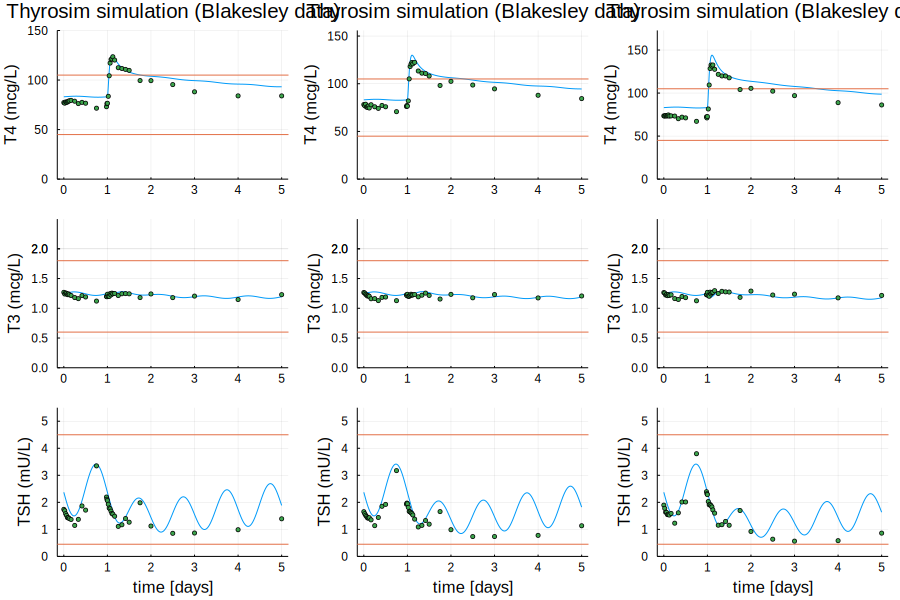

In [20]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
# ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, 1.61, 58, false) 
p[fitting_index] = initial_guess

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600")

plot(a, b, c, layout=(1, 3), size=(900, 600))

## Blakesley post fit

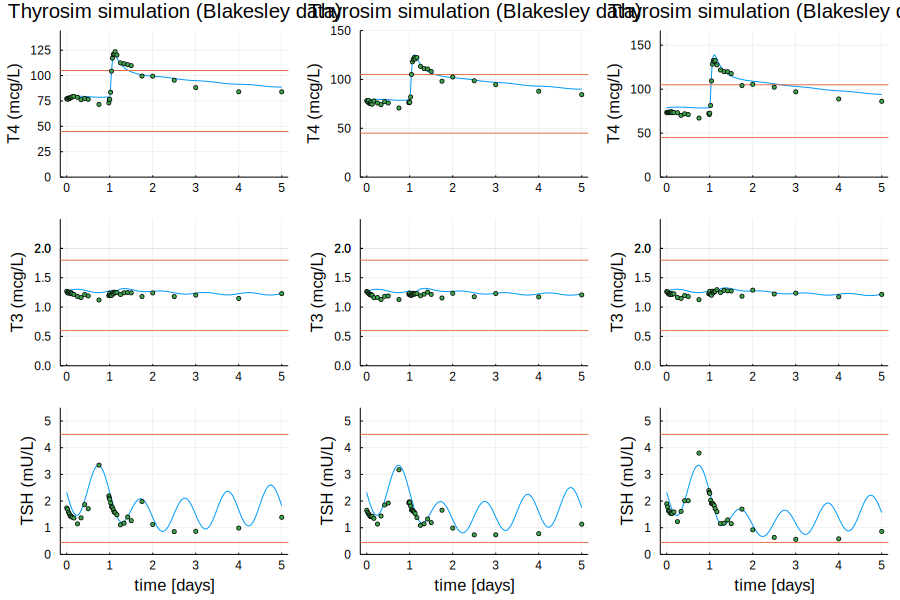

In [21]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = result.minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
# set_patient_ic!(ic, p, T4_init_400, T3_init_400, TSH_init_400)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
find_patient_ic!(ic, p, 30)
# set_patient_ic!(ic, p, T4_init_450, T3_init_450, TSH_init_450)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
find_patient_ic!(ic, p, 30)
# set_patient_ic!(ic, p, T4_init_600, T3_init_600, TSH_init_600, steady_state=true)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600")

plot(a, b, c, layout=(1, 3), size=(900, 600))

# Simulate patients (prefit)

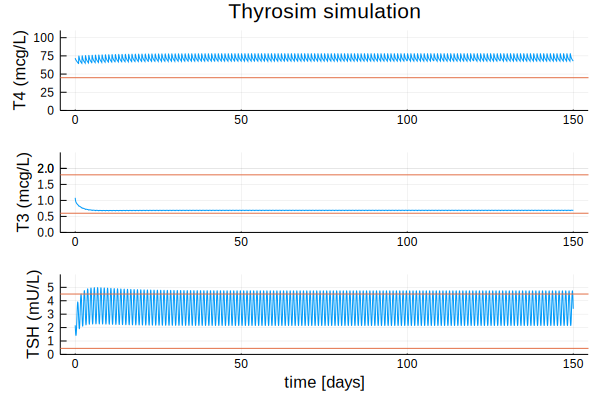

In [35]:
# 1.7m, 70kg, female patient
w = 70.0
sol = simulate(1.7, w, false, fitting_index=fitting_index, parameters=initial_guess,
    dial=[0.0; 0.88; 0.0; 0.88], days=150, T4dose=1.6w) 
output_plot(sol)

# Simulate patients (postfit)

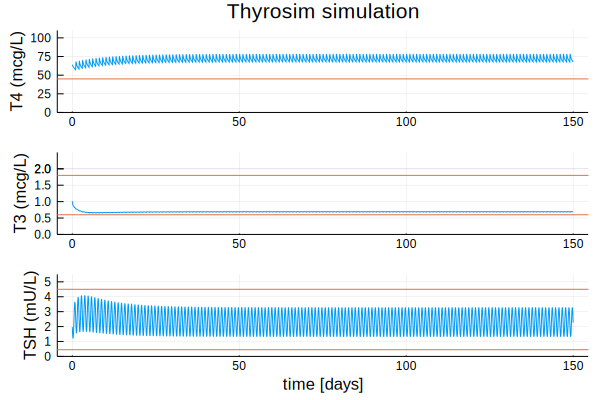

In [36]:
# 1.7m, 70kg, female patient
w = 70.0
sol = simulate(1.7, w, false, fitting_index=fitting_index, parameters=result.minimizer,
    dial=[0.0; 0.88; 0.0; 0.88], days=150, T4dose=1.6w) 
output_plot(sol)

# Jonklaas new postfit

In [19]:
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
# simulate jonklaas patient over 16 weeks, interpolating weights weekly, returning T4/T3/TSH values
function simulate_one_jonklaas_patient_new(
    patient_idx::Int,
    result_minimzer::Vector, # first n elem is parameters, n+1:end is T4/T3 secrete rates
    fitting_index::Vector, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    )
    # return vectors
    T4 = Float64[]
    T3 = Float64[]
    TSH = Float64[]
    times = Float64[]
    
    # other parameters
    dial = [1.0; 0.88; 1.0; 0.88]
    nparams = length(fitting_index)
    nsamples = size(jonklaas_patient_param, 1)
    cbk = PeriodicCallback(add_dose!, 24) 
    weight_w1 = jonklaas_patient_param[:, 1] # week 1 weight
    height = jonklaas_patient_param[:, 3]
    sex = convert(BitVector, jonklaas_patient_param[:, 4])

    # run model to steady state before actual simulation
    dial[1] = result_minimzer[nparams + 2patient_idx - 1]
    dial[3] = result_minimzer[nparams + 2patient_idx]
    sol = simulate(height[patient_idx], weight_w1[patient_idx], sex[patient_idx], days=50, dial=dial, 
        warmup=false, fitting_index=fitting_index, parameters=result_minimzer[1:length(fitting_index)])
    _, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx], sex[patient_idx])
    p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
    
    # run first 8 week simulations, interpolate weight weekly
    weight_diff = (jonklaas_patient_param[patient_idx, 2] - jonklaas_patient_param[patient_idx, 1]) / 16.0
    dial[1] = dial[3] = 0.0
    for week in 1:8
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, 
            sex[patient_idx])
        p[55] = jonklaas_patient_dose[patient_idx, 1] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = week == 1 ? 777.0 * sol[1, :] / p[47] : vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = week == 1 ? 651.0 * sol[4, :] / p[47] : vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = week == 1 ? 5.6 * sol[7, :] / p[48] : vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = week == 1 ? sol.t : vcat(times, sol.t[2:end] .+ times[end])
    end

    # run next 8 week, interpolate weight weekly
    println("week 1-8  dose = ", jonklaas_patient_dose[patient_idx, 1])
    println("week 9-16 dose = ", jonklaas_patient_dose[patient_idx, 2])
    for week in 9:16
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, sex[patient_idx])
        p[55] = jonklaas_patient_dose[patient_idx, 2] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = vcat(times, sol.t[2:end] .+ times[end])
    end
    
    return T4, T3, TSH, times
end

function plot_jonklaas_new(
    patient_idx::Int,
    T4::Vector,    # simulated T4
    T3::Vector,    # simulated T3
    TSH::Vector,   # simulated TSH
    times::Vector, # time intervals (units = days)
    FT4data::Matrix,    # data
    T3data::Matrix,    # data
    TSHdata::Matrix;   # data
    title::AbstractString="Thyrosim simulation (Jonklaas new data)",
    automargins::Bool=true
    )

    markersize = 2
    #time in which data are measured
    t_data = [0.0, 56, 112] # 8 and 16 weeks
    T4data = [FT4_to_TT4(FT4data[patient_idx, 2], Vb) * 777 / Vp, 
              FT4_to_TT4(FT4data[patient_idx, 3], Vb) * 777 / Vp, 
              FT4_to_TT4(FT4data[patient_idx, 4], Vb) * 777 / Vp]
    
    # parameters to adjust figure limits
    t4lim, t3lim, tshlim = 140, 4, 10
    if automargins
        t4lim = max(1.2maximum(T4), 110.0, 1.2T4data...)
        t3lim = max(1.2maximum(T3), 2.5)
        tshlim = max(1.2maximum(TSH), 5.5)
    end

    p1 = plot(times, T4, ylim=(0, t4lim), label="",ylabel="T4 (mcg/L)", title=title)
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, T4data, label="", markersize=markersize)

    p2 = plot(times, T3, ylim=(0, t3lim), label="", ylabel="T3 (mcg/L)")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, T3data[patient_idx, 2:4], label="", markersize=markersize)

    p3 = plot(times, TSH, ylim=(0, tshlim), label="", ylabel="TSH (mU/L)", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, TSHdata[patient_idx, 2:4], label="", markersize=markersize)

    plot(p1, p2, p3, layout=(3, 1))
end

plot_jonklaas_new (generic function with 1 method)

week 1-8  dose = 150.0
week 9-16 dose = 137.0


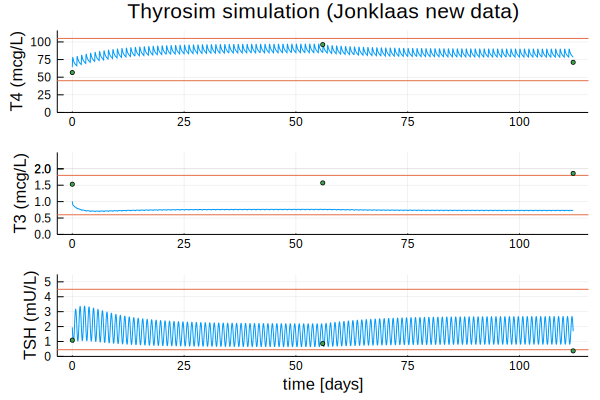

In [20]:
fitting_index = 
    [1; 21; 22; 
    30; 31; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]

jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

# make simulation
idx = 3
T4, T3, TSH, times = simulate_one_jonklaas_patient_new(idx, result.minimizer, 
    fitting_index, jonklaas_patient_param, jonklaas_patient_dose)
plot_jonklaas_new(idx, T4, T3, TSH, times ./ 24, patient_t4, patient_t3, patient_tsh)

## Jonklaas postfit

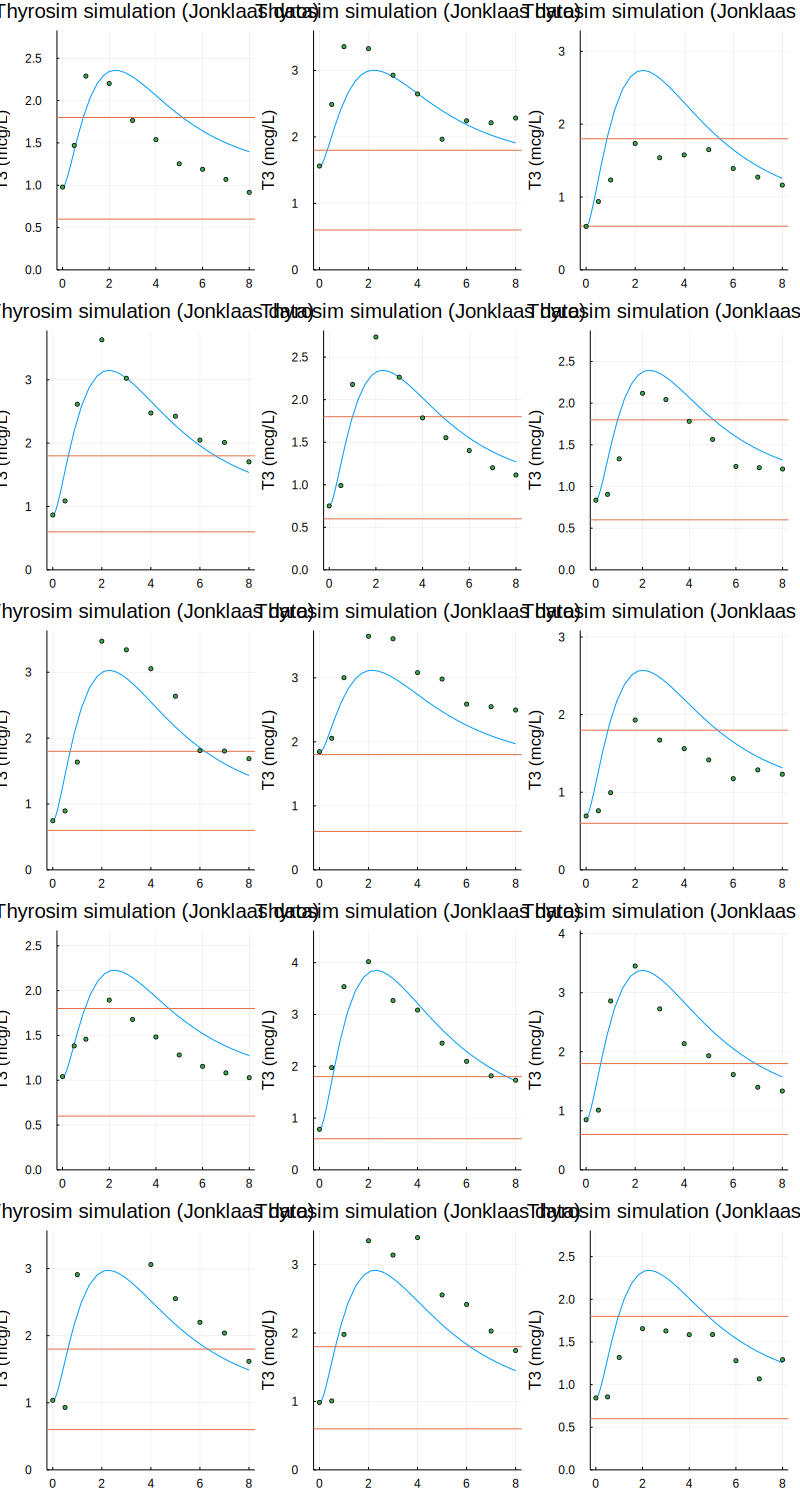

In [19]:
graphs = Vector{Any}(undef, 15)
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = result.minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    graphs[i] = plot_jonklaas_T3only(sol, patient_t3[i, :])
end
plot(graphs..., layout=(5, 3), size=(800, 1500))

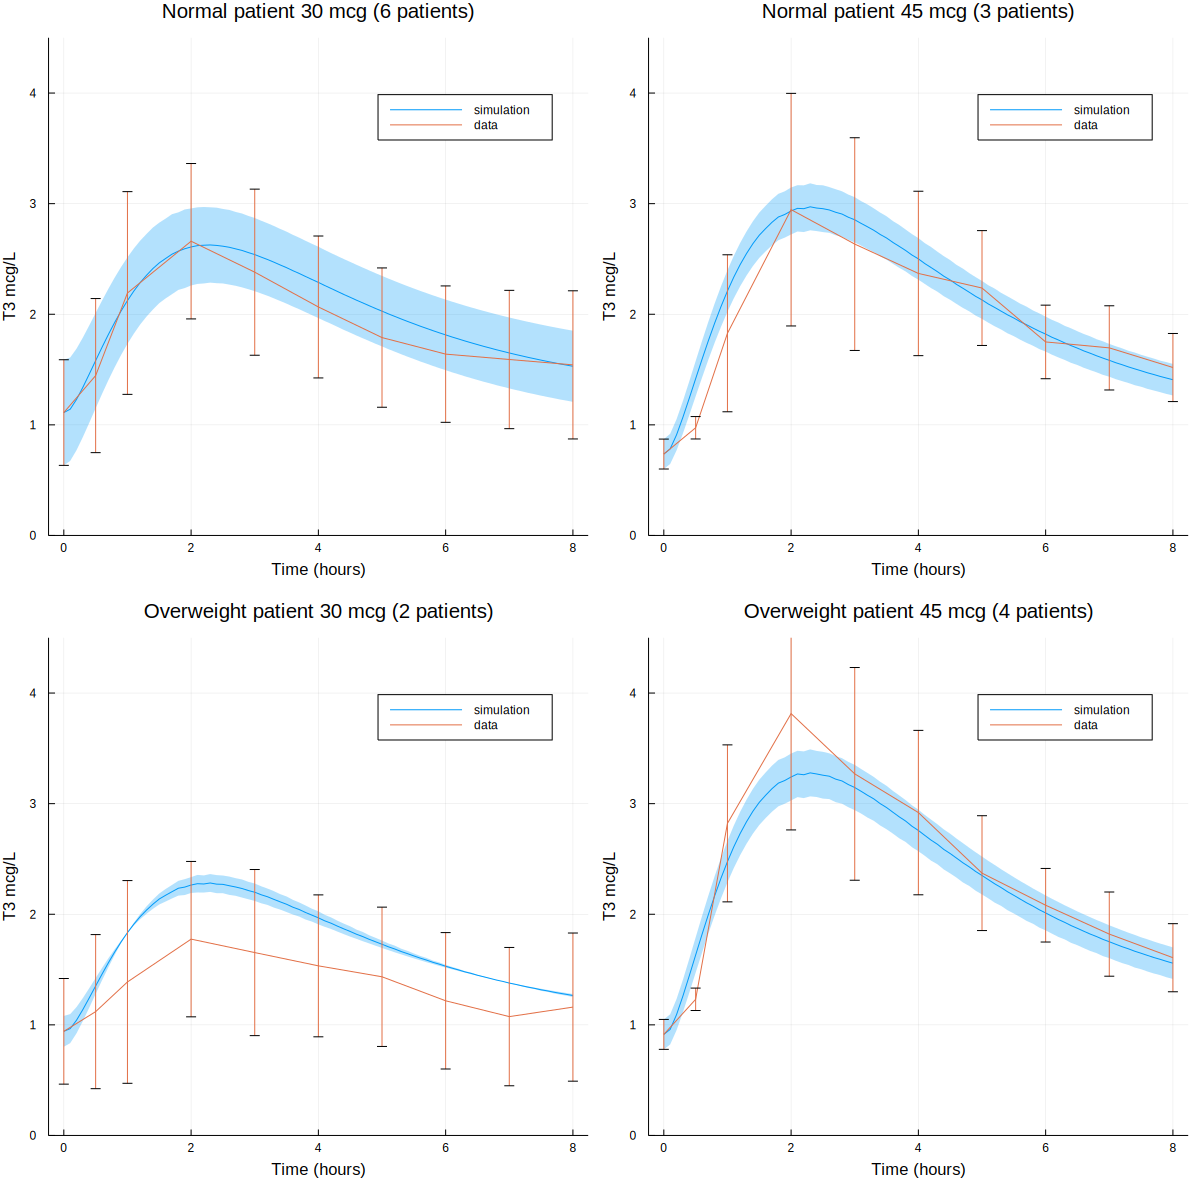

In [20]:
function jonklass_plot()
    jonklaas_times_simulation = collect(0.0:0.1:8.0)
    jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
    points = length(jonklaas_times_simulation)
    normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
    normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
    overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
    overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

    for i in 1:15
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        T3dose = patient_dose[i]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        p[55] = 0.0
        p[56] = T3dose / 651.0
        cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
        p[fitting_index] = result.minimizer
        prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
        sol = solve(prob)

        BMI = weight / height^2
        if BMI < 30
            # normal patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        else
            # overweight patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        end
    end

    # compute averages
    normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
    normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
    normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
    normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
    normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
    normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
    overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
    overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
    overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
    overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

    # compute sample standard deviations
    normal_45_T4_std = std.(normal_45_T4)      # 3 patients
    normal_45_T3_std = std.(normal_45_T3)      # 3 patients
    normal_45_TSH_std = std.(normal_45_TSH)     # 3 patients
    normal_30_T4_std = std.(normal_30_T4)      # 6 patients
    normal_30_T3_std = std.(normal_30_T3)      # 6 patients
    normal_30_TSH_std = std.(normal_30_TSH)     # 6 patients
    overweight_45_T4_std = std.(overweight_45_T4)  # 4 patients
    overweight_45_T3_std = std.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_std = std.(overweight_45_TSH) # 4 patients
    overweight_30_T4_std = std.(overweight_30_T4)  # 2 patients
    overweight_30_T3_std = std.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_std = std.(overweight_30_TSH); # 2 patients

    # now add data
    normal_45_T4_data  = zeros(10, 3)     # 3 patients
    normal_45_T3_data  = zeros(10, 3)     # 3 patients
    normal_45_TSH_data = zeros(10, 3)     # 3 patients
    normal_30_T4_data  = zeros(10, 6)     # 6 patients
    normal_30_T3_data  = zeros(10, 6)     # 6 patients
    normal_30_TSH_data = zeros(10, 6)     # 6 patients
    overweight_45_T4_data  = zeros(10, 4) # 4 patients
    overweight_45_T3_data  = zeros(10, 4) # 4 patients
    overweight_45_TSH_data = zeros(10, 4) # 4 patients
    overweight_30_T4_data  = zeros(10, 2) # 2 patients
    overweight_30_T3_data  = zeros(10, 2) # 2 patients
    overweight_30_TSH_data = zeros(10, 2) # 2 patients

    normal_45_counter = 1
    normal_30_counter = 1
    overweight_45_counter = 1
    overweight_30_counter = 1
    for i in 1:15
        height, weight, sex = patient_param[i, :]
        BMI = weight / height^2
        T3dose = patient_dose[i]

        if BMI < 30
            # normal patient
            if T3dose == 30
                normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
                normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
                normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
                normal_30_counter += 1
            else
                normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
                normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
                normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
                normal_45_counter += 1
            end
        else
            # overweight patient
            if T3dose == 30
                overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
                overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
                overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
                overweight_30_counter += 1
            else
                overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
                overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
                overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
                overweight_45_counter += 1
            end
        end
    end

    # mean and std of data
    normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
    normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
    overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
    normal_45_T3_data_std = std(normal_45_T3_data, dims=2)
    normal_30_T3_data_std = std(normal_30_T3_data, dims=2)
    overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2);

    # normal patients 45 mcg T4 plot
    normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal patient 45 mcg (3 patients)")
    normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # normal patients 30 mcg T4 plot
    normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal patient 30 mcg (6 patients)")
    normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std)

    # overweight patients 45 mcg T4 plot
    overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight patient 45 mcg (4 patients)")
    overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # overweight patients 30 mcg T4 plot
    overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight patient 30 mcg (2 patients)")
    overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std);
    
    combine = plot(normal_30_graph, normal_45_graph, 
        overweight_30_graph, overweight_45_graph, 
        layout=(2, 2), size=(1200, 1200))
    return combine
end
combine = jonklass_plot()